**Проект заточен на то, чтобы предсказать культуру производственной безопасности (КПБ) каждого работника с помощью методов ML и DL. В конце концов, выбрать наилучшую модель для дальнейшего пользования университетом РГУ нефти и газа имени Губкина.**

# Импорт библиотек

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')


# Просмотр данных и предобработка

In [5]:
file_2020 = pd.read_excel('/kaggle/input/data-assessment/2020.xlsx')
file_2020_addition = pd.read_excel('/kaggle/input/data-assessment/2020_.xlsx')
file_2021 = pd.read_excel('/kaggle/input/data-assessment/2021.xlsx')
file_2022_2023 = pd.read_excel('/kaggle/input/data-assessment/2022_2023.xlsx')

**Сначала приведём все столбцы к одинаковому формату.**

In [80]:
file_2020.columns

Index(['1. Ваш возраст?', '2. Каков Ваш стаж работы по профессии?',
       '3. Укажите уровень занимаемой Вами должности',
       '4. Как Вы считаете, имеется ли возможность выполнять все требования безопасности в процессе Вашей трудовой деятельности?',
       '5. Допускали ли Вы в ходе работы ошибки, которые могли повлечь снижение уровня безопасности? ',
       '6. Возможно ли, по Вашему мнению, в имеющихся условиях трудовой деятельности достичь показателя нулевого травматизма? ',
       '7. Оцените, пожалуйста, по шкале от 1 до 5 общее состояние безопасности Вашей трудовой деятельности.',
       '8. Как Вы оцениваете свой вклад в обеспечении и развитии безопасности компании (в %, от 0 до 100)?',
       '9. Приходилось ли Вам ранее принимать участие в поведенческом аудите безопасности?',
       '10. Готовы ли Вы взять на себя ответственность прервать технологический процесс в случае предаварийной ситуации или при обнаружении небезопасных действий коллег?',
       'КПБ'],
      dtype='

In [6]:
file_2020.columns = file_2020_addition.columns = file_2021.columns = file_2022_2023.columns = [
    'Age',
    'Experience',
    'Post',
    'The ability to perform security',
    'There were security errors',
    'There are risks at work',
    'Security status',
    "Contribution to the company's security",
    'Participation in the audit',
    'Interrupt work in case of danger',
    'КПБ'
]

In [4]:
file_2020.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


**Так как столбцы во всех файлах одинаковые, сделаем concat.**

In [7]:
data = pd.concat([file_2020, file_2020_addition, file_2021, file_2022_2023], axis=0, ignore_index=True)
len(data) == len(file_2020) + len(file_2020_addition) + len(file_2021) + len(file_2022_2023)

True

In [6]:
data.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [7]:
len(data)

30659

**Теперь необходимо исключить пропуски из данных.**

In [8]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.861557
718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.949581
820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data = data.dropna()
len(data)

30633

**Проверим данные на наличие аномалий в каждом столбце.**

In [10]:
data.describe()

,Security status,КПБ
count,30633.000000,30633.000000
mean,4.434433,3.712863
std,0.741729,0.509239
min,1.000000,1.000000
25%,4.000000,3.375000
50%,5.000000,3.718750
75%,5.000000,3.984375
max,5.000000,5.000000


In [11]:
data.dtypes

Age                                        object
Experience                                 object
Post                                       object
The ability to perform security            object
There were security errors                 object
There are risks at work                    object
Security status                           float64
Contribution to the company's security     object
Participation in the audit                 object
Interrupt work in case of danger           object
КПБ                                       float64
dtype: object

In [9]:
''' Функции для работы с неопределёнными значениями'''

def not_int(x):
    if type(x) != int:
        return True

def not_float(x):
    if type(x) != float:
        return True
    
def clear_data(data, label, func):
    indexes = data[data[label].apply(lambda x: func(x)) == True].index
    print(f'количество аномалий: {len(data[data[label].apply(lambda x: func(x)) == True])}')
    data = data.drop(indexes)
    return data

In [10]:
data = clear_data(data, 'Age', not_int)

количество аномалий: 122


In [11]:
data = clear_data(data, 'Experience', not_int)

количество аномалий: 1134


In [12]:
data = clear_data(data, "Contribution to the company's security", not_int)

количество аномалий: 161


In [13]:
print(f'Количество данных после удаления аномалий в числовых столбцах: {len(data)}')

Количество данных после удаления аномалий в числовых столбцах: 29216


In [17]:
data.columns

Index(['Age', 'Experience', 'Post', 'The ability to perform security',
       'There were security errors', 'There are risks at work',
       'Security status', 'Contribution to the company's security',
       'Participation in the audit', 'Interrupt work in case of danger',
       'КПБ'],
      dtype='object')

In [11]:
print(data['Post'].nunique())
print(data['The ability to perform security'].nunique())
print(data['There were security errors'].nunique())
print(data['There are risks at work'].nunique())
print(data['Participation in the audit'].nunique())
print(data['Interrupt work in case of danger'].nunique())

8
3
3
3
2
3


**Можно сделать вывод, что в категориальных столбцах нет аномалий, поэтому оставим всё как есть.**

# Визуализация и работа с выбросами

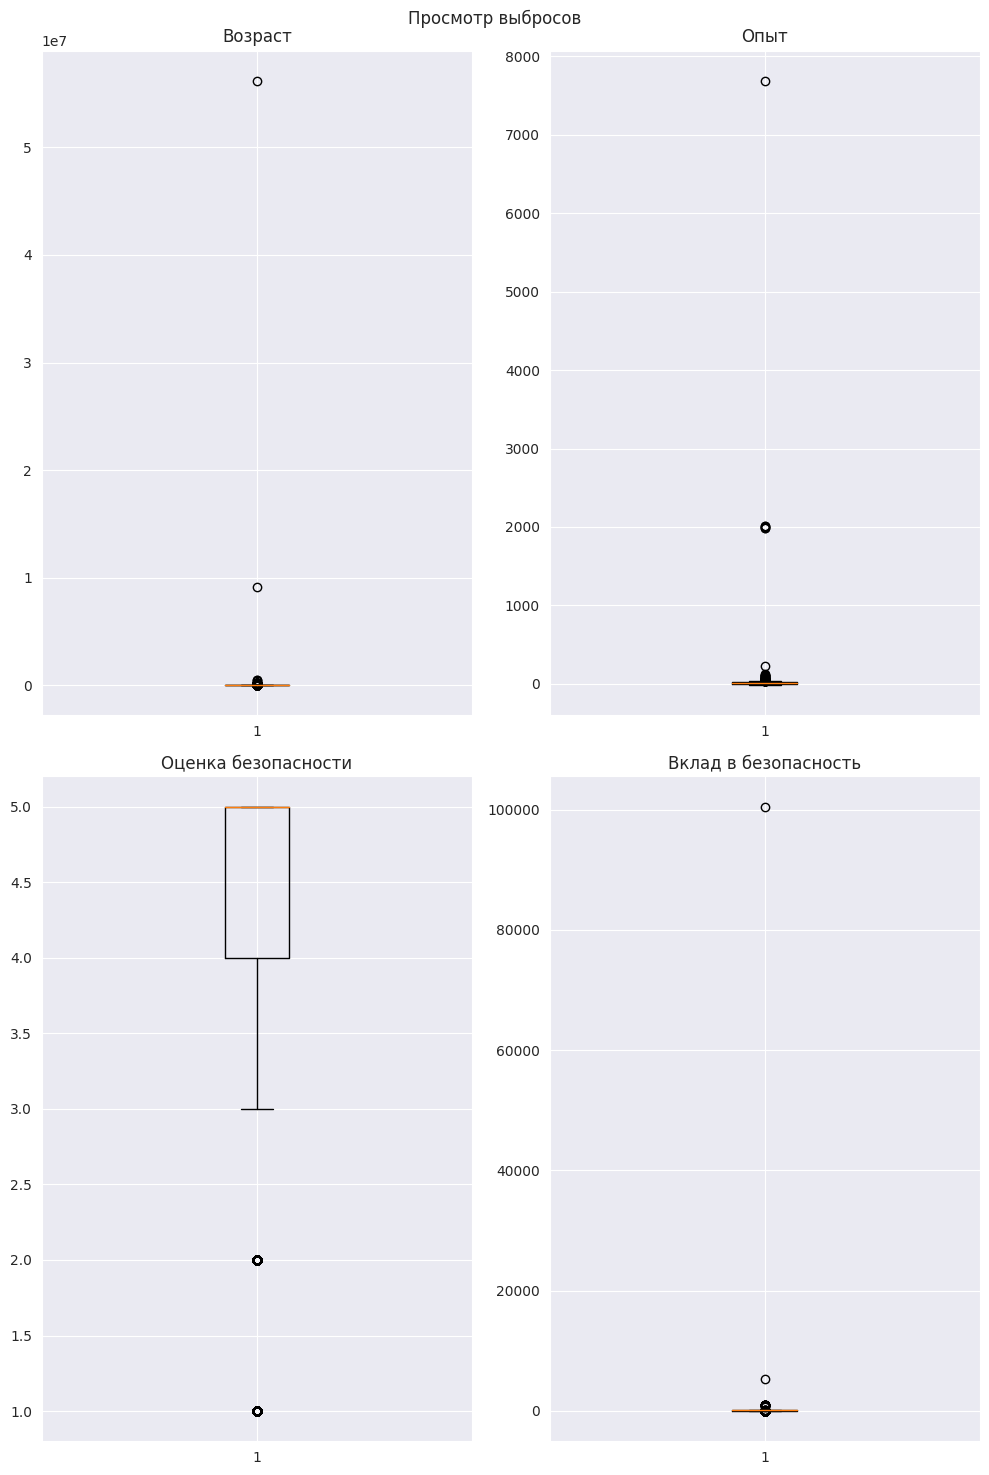

In [14]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [15]:
data = data[(data['Age'] <= 100) & (data['Age'] >= 18)]
data = data[(data['Experience'] <= 60) & (data['Experience'] >= 0)]
data = data[(data["Contribution to the company's security"] <= 100) &
            (data["Contribution to the company's security"] >= 0)]

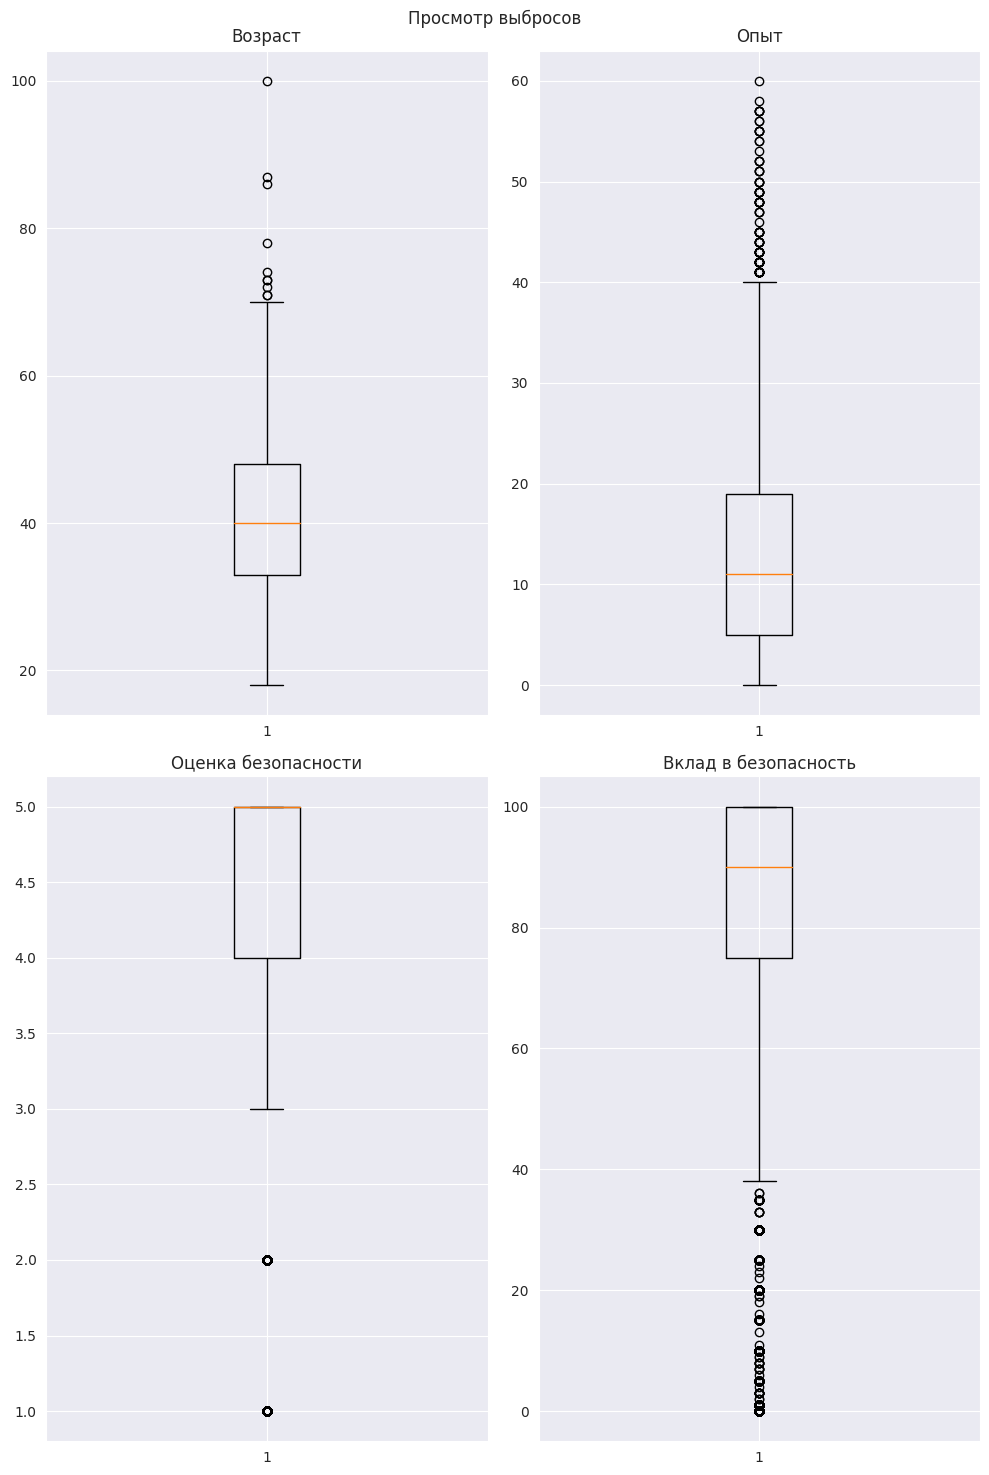

In [16]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [17]:
len(data)

29022

# Подготовка данных к модели

In [18]:
X = data.drop(['КПБ'], axis=1)
y = data[['КПБ']]

In [31]:
y.dtypes

КПБ    float64
dtype: object

In [32]:
X.dtypes

Age                                        object
Experience                                 object
Post                                       object
The ability to perform security            object
There were security errors                 object
There are risks at work                    object
Security status                           float64
Contribution to the company's security     object
Participation in the audit                 object
Interrupt work in case of danger           object
dtype: object

In [20]:
categorical_columns = ['Post', 'The ability to perform security', 'There were security errors',
                      'There are risks at work', 'Participation in the audit',
                      'Interrupt work in case of danger']
int_columns = ['Age', 'Experience', "Contribution to the company's security"]
X[int_columns] = X[int_columns].astype('int32')
num_columns = ['Age', 'Experience', 'Security status', "Contribution to the company's security"]

In [75]:
assert len(categorical_columns) + len(num_columns) == 10

In [21]:
def encode(df, cols):
    encode_dict = {}
    for col in cols:
        print(f'{col}: преобразовалась')
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df[col].values) 
        df[col] = label_encoder.transform(df[col].values)
        encode_dict[col] = label_encoder
    return df, encode_dict

X_cat, encode_dict = encode(X, categorical_columns)

Post: преобразовалась
The ability to perform security: преобразовалась
There were security errors: преобразовалась
There are risks at work: преобразовалась
Participation in the audit: преобразовалась
Interrupt work in case of danger: преобразовалась


In [77]:
encode_dict

{'Post': LabelEncoder(),
 'The ability to perform security': LabelEncoder(),
 'There were security errors': LabelEncoder(),
 'There are risks at work': LabelEncoder(),
 'Participation in the audit': LabelEncoder(),
 'Interrupt work in case of danger': LabelEncoder()}

In [22]:
scaler_dict = {}
for col in num_columns:
    scaler = StandardScaler()
    scaler_dict[col] = scaler.fit(X[col].values.reshape(-1, 1))
    X[col] = scaler_dict[col].transform(X[col].values.reshape(-1, 1))

In [23]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.592549,0.788456,3,0,2,0,0.758893,-0.300736,0,0
1,-0.365291,0.242006,3,0,2,2,0.758893,0.837947,0,0
2,-0.046011,0.242006,3,0,2,0,0.758893,0.837947,1,0
3,0.060416,0.679166,0,0,0,0,0.758893,0.837947,0,0
4,-0.258864,0.460586,2,0,0,0,0.758893,0.837947,1,1


In [24]:
scaler_dict

{'Age': StandardScaler(),
 'Experience': StandardScaler(),
 'Security status': StandardScaler(),
 "Contribution to the company's security": StandardScaler()}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

# Baseline модель

In [35]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, train_size=0.9, \
                                                                     random_state=42)

base_model = LinearRegression()
base_model.fit(X_train_base, y_train_base)
preds = base_model.predict(X_val_base)

print(f'Вычисленное отклонение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное отклонение rmse: 0.434386892373028


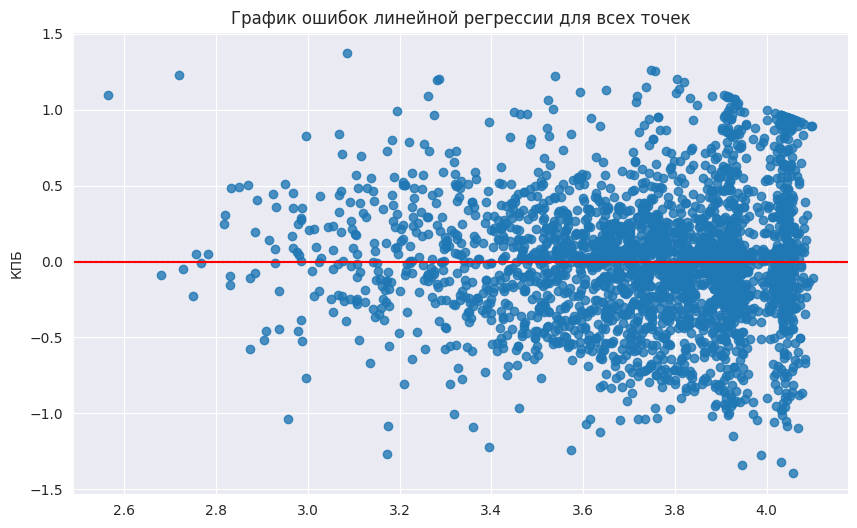

In [36]:
plt.figure(figsize=(10,6), dpi=100)
sns.residplot(x=preds, y=y_val_base);
plt.axhline(y=0, color='r');
plt.title('График ошибок линейной регрессии для всех точек');

# XGBoost, Catboost

In [68]:
def training_model_with_randomsearch(model, X_train, y_train, X_test, y_test, params_dict):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_dict,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error', 
        verbose=1
    )
    random_search.fit(X_train, y_train)
    preds = random_search.predict(X_test)
    print("Лучшие гиперпараметры:", random_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

In [71]:
def training_model_with_gridsearch(model, X_train, y_train, X_test, y_test, params_dict):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params_dict,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

**XGBoost**

In [46]:
params_dict = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_randomsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:57:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Лучшие гиперпараметры: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05}
Вычисленное значение rmse: 0.4204035387717541


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:57:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:57:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [53]:
params_dict = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [5, 7, 9],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_gridsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.7}
Вычисленное значение rmse: 0.42035339180395487


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:14:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:14:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


**Catboost**

In [74]:
params = {
    'depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 700, 900],
    'l2_leaf_reg': [7, 9, 11],
}
cat = CatBoostRegressor(task_type='GPU', verbose=0)

In [72]:
training_model_with_randomsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 8}
Вычисленное значение rmse: 0.4200003979001295


In [75]:
training_model_with_gridsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Лучшие гиперпараметры: {'depth': 10, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.05}
Вычисленное значение rmse: 0.4197315524979759
